# Replaying Old Data

- Work under a separate branch with git (i.e. git checkout -b my-new-branch)

- Make a new folder in Projects (for your specific purposes)

- Copy this ipynb file that folder

- The data is stored on L-Drive

- the main gist of re-playing existing data is:
    - that your first load everything into a big matrix with mne
    - then initialize a specific **amp** (i.e., the "replayamp")
    - then do exactly the same as normal, with a while True loop with calls to amp.get_data()
    

In [1]:
# import all the needed stuff:

import time
import sys
import numpy as np 
import matplotlib
import matplotlib.pyplot as plt

import easygui  # popup windows with buttons made easy
import mne  # EEGLAB for python
from IPython.display import clear_output  # to clear the cell output during while loop
import re  # regular expressions
import pickle  # to save/load data
import dynarray  # a growing numpy array

import logging
logging.basicConfig(level=logging.ERROR)

sys.path.append("../../mushu")  # driver for the amps
sys.path.append("../../mushu/libmushu")
import libmushu

sys.path.append("../../nftools")  # handy stuff needed for NF
from nftools.loopcontrol import LoopState
from nftools.analysis import convert_alld_allm_to_mne
from nftools.analysis import select_part_from_mne_dataset
from nftools.analysis import plot_compare_two_spectra


sys.path.append("../../wyrm")  # real-time data analysis
from wyrm.types import RingBuffer
from wyrm.types import BlockBuffer
from wyrm import io
from wyrm import processing as proc

import scipy
from scipy import signal

from collections import deque  # a FILO list useful for plotting!

In [2]:
amp = libmushu.get_amp('lslamp')

In [3]:
amp.configure()

In [9]:
alld=dynarray.DynamicArray((None, len(amp.get_channels())))     # data
allm=[]     # markers
sfreq = amp.get_sampling_frequency()  # sampling frequency
ch_names=amp.get_channels()  # channel names

markTime=time.time()


rb = RingBuffer(buffSize * 1000)  # the buffer containing the last X seconds of data - declared in MILISECONDS
totalTime = seed_d.shape[0]/raw_fromfile.info['sfreq']

In [4]:
amp.start()

In [21]:
d, m = amp.get_data()

NameError: name 'sx' is not defined

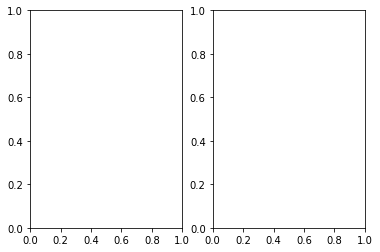

In [5]:
fig=plt.figure()  # plotting...
th=fig.suptitle('')
ah1=fig.add_subplot(121)
ah2=fig.add_subplot(122)
l1, = ah1.plot(sx, sy1)
l2, = ah2.plot(sx, sy2)



# l=LoopState(); l.start()
markeroffset = 0  # needed to store all data in one big mat/vector
t0=time.time()
curTime=time.time()
st=''
while curTime - t0 < totalTime:  # l.get_state() != 'Stop':
   
    
    # keep track of time:
    curTime = time.time()
    
    # this is where you get the data
    data, marker = amp.get_data()
    

    
    if data.shape[0] > 0:  # this is crucial for remembering filter state.

        dataf, rt_zi_bp = signal.lfilter(rt_b_bp, rt_a_bp, data, axis=0, zi=rt_zi_bp)  # how to operate directly on the data
        
        cnt = io.convert_mushu_data(data, marker, sfreq, ch_names)
        f_cnt = cnt # io.convert_mushu_data(dataf, marker, sfreq, ch_names)

        # f_cnt, rt_zi_bp = proc.lfilter(cnt, rt_b_bp, rt_a_bp, zi=rt_zi_bp)  # real-time data preprocessing...

        # plotting...
        sy1.extend(cnt.data[:,channel_to_plot])  # to visualize/plot -- s1 and s2 are deque's
        sy2.extend(f_cnt.data[:,channel_to_plot])
        l1.set_ydata(sy1)
        l2.set_ydata(sy2)
        msy1=np.mean(sy1)
        msy2=np.mean(sy2)
        ah1.set_ylim(-5000+msy1, 5000+msy1)
        ah2.set_ylim(-100+msy2, 100+msy2)

        fig.canvas.draw()
        fig.canvas.flush_events()
        
        # currently has no purpose
        newsamples = cnt.data.shape[0]

        # append to ringbuffer, so we can calculate features later on on the last N secs/samples of data.
        rb.append(f_cnt)

        # append it to the big matrix, for saving later on with pickle.
        alld.extend(data)
        for m in marker:
            allm.append([m[0] + markeroffset, m[1]])
        markeroffset += newsamples / float(sfreq) * 1000.
        


        # do the following every 0.1 msec - with with the ringbuffer:
        if curTime - markTime > updateTime:
            # do Stuff

            markTime = curTime
            # 1) obtain last 1-second(s)
            d = rb.get()

            

            # clear_output(wait=True)  # write some logging information here
            # clear_output clear the output of the cell, but if you do that you also remove the figures, it seems
            # so don't do it!
            str1 = 'Playing Back - time = %f' % (curTime - t0)
            str2 = 'Length Markers: %d' % len(allm)
            str3 = '%d, %d' % data.shape
            #str4 = 'Feature Value: %f' % feature
            #str5 = 'Scaled Signal for NF: %f' % signalToSend
            #print(str1 + '\n' + str2 + '\n' + str3 + '\n' + str4 + '\n' + str5)
            
            # print('Length Markers: %d' % len(allm))
            # print(data.shape)
            th.set_text(str1 + '\n' + str2 + '\n' +str3)
            #featureth.set_text(str4 + '\n' + str5)





In [36]:
amp.stop()
alld.shrink_to_fit()

amplifier stopped!


In [37]:
# write to disk, so we can re-load it later:

t={'alld':alld, 'allm':allm, 'ch_names':ch_names, 'sfreq':sfreq}
with open('c-allm-and-alld.pkl', 'wb') as f:
    pickle.dump(t, f)

In [16]:
# load from disk:

with open('c-allm-and-alld.pkl','rb') as f:
    t=pickle.load(f)
for key in t.keys():
    locals()[key] = t[key]

In [14]:
raw = convert_alld_allm_to_mne(alld, allm, ch_names, sfreq)  # covert to MNE
# raw.resample(1000)

The following EEG sensors did not have a position specified in the selected montage: ['EOG', 'ECG', 'CW1', 'CW2', 'CW3', 'CW4', 'CW5', 'CW6']. Their position has been left untouched.


../../nftools/nftools/analysis.py:31: RuntimeWarning: The following EEG sensors did not have a position specified in the selected montage: ['EOG', 'ECG', 'CW1', 'CW2', 'CW3', 'CW4', 'CW5', 'CW6']. Their position has been left untouched.
  montage=montage


Creating RawArray with float64 data, n_channels=38, n_times=400001
    Range : 0 ... 400000 =      0.000 ...    80.000 secs
Ready.
5000.0
Creating RawArray with float64 data, n_channels=1, n_times=400001
    Range : 0 ... 400000 =      0.000 ...    80.000 secs
Ready.


In [15]:
raw

<RawArray  |  None, n_channels x n_times : 39 x 400001 (80.0 sec), ~119.1 MB, data loaded>

In [19]:
raw.plot(scalings='auto');

In [19]:
# raw.set_eeg_reference(ref_channels='average')
# better not (yet) - before removing bad channels, since these mess up your data big time: see PREP paper:


In [16]:
picks = mne.pick_types(raw.info, meg=False, eeg=True, eog=False,
                       stim=False, exclude='bads')

raw.notch_filter(np.arange(50, 300, 50), picks=picks, filter_length='auto', phase='zero')
# add it (potentialy) some other preprocessing steps here

Setting up band-stop filter
Filter length of 33001 samples (6.600 sec) selected


<RawArray  |  None, n_channels x n_times : 39 x 400001 (80.0 sec), ~119.1 MB, data loaded>

In [17]:
raw.plot_psd(tmax=np.inf, fmax=1000, n_fft=2048*4);

Effective window size : 1.638 (s)


/home/johan/.conda/envs/rt/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
/home/johan/.conda/envs/rt/lib/python3.6/site-packages/numpy/core/_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)
/home/johan/.conda/envs/rt/lib/python3.6/site-packages/mne/viz/evoked.py:162: RuntimeWarning: invalid value encountered in maximum
  rgb /= np.maximum(rgb.max(0), 1e-16)  # avoid div by zero
/home/johan/.conda/envs/rt/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/johan/.conda/envs/rt/lib/python3.6/site-packages/matplotlib/colors.py:251: RuntimeWarning: invalid value encountered in less
  if np.any((result < 0) | (result > 1)):
/home/johan/.conda/envs/rt/lib/python3.6/site-packag

In [21]:
mne.viz.plot_sensors(raw.info, show_names=True);

/home/johan/.conda/envs/rt/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
